In [327]:
import pandas as pd

#데이터프레임에 각 테이블을 지정하는 과정
#쥬피터 노트북환경에서 하면 좋은 점 발견: 내용이 많은 데이터셋의 경우 매번 실행시키면 오래걸리기 때문에 데이터프레임을 한번 받아두고 다른 창에서 바로 명령문 실행 가능

path1 = '/content/sample_data/games.csv'
path2 = '/content/sample_data/games_details.csv'
path3 = '/content/sample_data/ranking.csv'

games = pd.read_csv(path1,low_memory=False)
wj_games = games.drop(columns=['GAME_DATE_EST','GAME_STATUS_TEXT','TEAM_ID_home','TEAM_ID_away'], inplace=False)
wj_games = wj_games[wj_games['SEASON']>=2019]
#GAME_ID를 통해 경기별로 분류 1=비정규,2=정규,3=플레이오프,4=플레이인
wj_games['SEASON_NAME']=wj_games['GAME_ID'] // 10000000

#pd.set_option('display.max_columns',None)


games_details = pd.read_csv(path2,low_memory=False)
wj_games_details = games_details.drop(columns=['NICKNAME','START_POSITION'], inplace=False)

ranking = pd.read_csv(path3,low_memory=False)
wj_ranking = ranking.drop(columns=['LEAGUE_ID','RETURNTOPLAY'], inplace=False)
wj_ranking['SEASON']=wj_ranking['SEASON_ID'].apply(lambda x : 2022 if x == 22022 else (
                                                                2021 if x == 22021 else (
                                                                2020 if x == 22020 else 2019
                                                                )
))
wj_ranking = wj_ranking[wj_ranking['SEASON_ID']>=20000] #비시즌(맨앞자리가 1은 프리시즌, 2는 정규시즌) 제거
wj_ranking=wj_ranking.drop(columns='SEASON_ID',inplace=False)
wj_ranking

,TEAM_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,SEASON
0,1610612743,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,2022
1,1610612763,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,2022
2,1610612740,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,2022
3,1610612756,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,2022
4,1610612746,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,2022
...,...,...,...,...,...,...,...,...,...,...,...
210337,1610612765,2014-09-01,East,Detroit,82,29,53,0.354,17-24,12-29,2019
210338,1610612738,2014-09-01,East,Boston,82,25,57,0.305,16-25,9-32,2019
210339,1610612753,2014-09-01,East,Orlando,82,23,59,0.280,19-22,4-37,2019
210340,1610612755,2014-09-01,East,Philadelphia,82,19,63,0.232,10-31,9-32,2019


In [328]:
#함수 선언 - PCT 컬럼을 계산하기 위함.

def pctmean(series):
    return series.mean() * 10


In [329]:
#랭킹 데이터에서 각 시즌별 성적 뽑기
pd.to_datetime(wj_ranking['STANDINGSDATE'])
#rankingdata에서 각 시즌 마지막 일자별 팀 기록 추출
roofmax = [2021,2020,2019]
maxdata = wj_ranking.loc[wj_ranking['SEASON']==2022,'STANDINGSDATE'].max()
rk_table = wj_ranking[wj_ranking['STANDINGSDATE']==maxdata].copy()
rk_table
for i in roofmax:
    maxdata = wj_ranking.loc[wj_ranking['SEASON']==i,'STANDINGSDATE'].max()
    rooftable = wj_ranking[wj_ranking['STANDINGSDATE']==maxdata].copy()
    rk_table = pd.concat([rk_table,rooftable])

rk_table = rk_table.drop(columns=['STANDINGSDATE'],inplace=False)
rk_table=rk_table.reset_index()
rk_table.drop(columns=['index'],inplace=True)
rk_table

,TEAM_ID,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,SEASON
0,1610612743,West,Denver,30,19,11,0.633,10-3,9-8,2022
1,1610612763,West,Memphis,30,19,11,0.633,13-2,6-9,2022
2,1610612740,West,New Orleans,31,19,12,0.613,13-4,6-8,2022
3,1610612756,West,Phoenix,32,19,13,0.594,14-4,5-9,2022
4,1610612746,West,LA Clippers,33,19,14,0.576,11-7,8-7,2022
...,...,...,...,...,...,...,...,...,...,...
115,1610612741,East,Chicago,65,22,43,0.338,14-20,8-23,2019
116,1610612752,East,New York,66,21,45,0.318,11-22,10-23,2019
117,1610612765,East,Detroit,66,20,46,0.303,11-22,9-24,2019
118,1610612737,East,Atlanta,67,20,47,0.299,14-20,6-27,2019


In [330]:
#COPY()를 사용하지 않으면 하위 테이블이 변화되었을때 상위 테이블에 영향을 줄 수 있음.
H_games = wj_games[['GAME_ID','SEASON_NAME','SEASON','HOME_TEAM_ID','PTS_home','FG_PCT_home','FT_PCT_home','FG3_PCT_home','AST_home','REB_home']].copy()
H_games['HA'] = 1
A_games = wj_games[['GAME_ID','SEASON_NAME','SEASON','VISITOR_TEAM_ID','PTS_away','FG_PCT_away','FT_PCT_away','FG3_PCT_away','AST_away','REB_away']].copy()
A_games['HA'] = 2
H_games.columns = ['GAME_ID','SEASON_NAME','SEASON','TEAM_ID','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','HA']
A_games.columns = ['GAME_ID','SEASON_NAME','SEASON','TEAM_ID','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','HA']
T_games = pd.concat([H_games,A_games])#.sort_values(by='SEASON',ascending=False)
T_games=T_games[T_games['SEASON_NAME']==2]
T_games=T_games.drop(columns=['GAME_ID','SEASON_NAME'])
T_games.groupby(['SEASON','TEAM_ID']).agg({'PTS':['mean','median'],
                                           'FG_PCT':[pctmean],
                                           'FT_PCT':[pctmean],
                                           'FG3_PCT':[pctmean],
                                           'AST':['mean','median'],
                                           'REB':['mean','median'],
                                           'HA':'sum'
                                           })

PTS           FG_PCT    FT_PCT   FG3_PCT        AST  \
                         mean median   pctmean   pctmean   pctmean       mean   
SEASON TEAM_ID                                                                  
2019   1610612737  111.761194  112.0  4.502985  7.883582  3.324478  23.955224   
       1610612738  113.652778  112.0  4.619167  8.029167  3.658472  22.986111   
       1610612739  106.892308  108.0  4.599077  7.574000  3.478154  23.076923   
       1610612740  115.847222  116.0  4.661528  7.269583  3.698889  26.833333   
       1610612741  106.846154  108.0  4.478923  7.518923  3.479692  23.230769   
...                       ...    ...       ...       ...       ...        ...   
2022   1610612762  117.028571  118.0  4.750857  7.662000  3.736286  26.085714   
       1610612763  115.366667  115.0  4.674333  7.222333  3.500667  25.000000   
       1610612764  110.757576  111.0  4.766061  7.627273  3.455152  24.606061   
       1610612765  110.764706  112.0  4.492941  7.812647  3.421176  21.941176   
       1610612766  110.593750  112.0  4.439375  7.369687  3.238437  24.593750   

                                REB          HA  
                  median       mean median  sum  
SEASON TEAM_ID                                   
2019   1610612737   24.0  43.253731   43.0  100  
       1610612738   23.0  46.069444   45.0  108  
       1610612739   23.0  44.261538   45.0   94  
       1610612740   26.0  46.500000   46.0  108  
       1610612741   24.0  41.861538   42.0   96  
...                  ...        ...    ...  ...  
2022   1610612762   27.0  43.400000   43.0   53  
       1610612763   26.0  48.833333   49.5   45  
       1610612764   24.0  43.484848   44.0   51  
       1610612765   22.5  42.911765   42.0   52  
       1610612766   25.0  45.687500   45.0   49  

[120 rows x 10 columns]

In [331]:
#games_details 테이블에 시즌이라는 개념 추가, 2019 ~ 2022 시즌만 짜르기
Season_player = wj_games_details[21900000<=wj_games_details['GAME_ID']]
Season_player = Season_player[Season_player['GAME_ID']<23000000]

#시즌 컬럼 만들기
#시즌 나누기
Season_player['SEASON'] = Season_player['GAME_ID'].apply(lambda x : 2022 if round((x/100000)-200,0)==22 else
                                                                (2021 if round((x/100000)-200,0)==21 else
                                                                (2020 if round((x/100000)-200,0)==20 else 2019 )))
#팀 LA_LAKERS만 뽑아보기
LA_lakers = Season_player[Season_player['TEAM_ABBREVIATION']=='LAL'].copy()

#당장 불필요한 컬럼 정리, Season별 혹은 LA레이커스 선수들의 시즌별 데이터 정리, cnt_season은 게임수를 groupby 후에 mean() 또는 sum()을 해주어야해서 GAME_ID 컬럼을 삭제하기 전에 이용
Season_player.drop(columns=['TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY','COMMENT'],inplace=True)
cnt_season=Season_player.groupby(['GAME_ID','PLAYER_ID','PLAYER_NAME','SEASON'])[[
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS']].sum()
Season_player.drop(columns=['GAME_ID'],inplace=True)
#Season_player = Season_player.fillna(0) #결측값제거 (0으로 대체) 결측값 제거시 경기수 측정하기 불편.
sn_count = Season_player[['PLAYER_ID','PLAYER_NAME','SEASON','FGM']].groupby(['PLAYER_ID','PLAYER_NAME','SEASON']).count().reset_index()
sn_count.columns = ['PLAYER_ID','PLAYER_NAME','SEASON','GP'] #전체팀들의 선수들 출전수
LA_lakers.drop(columns=['GAME_ID','TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY','COMMENT'],inplace=True)
#LA_lakers = LA_lakers.fillna(0) #결측값제거 (0으로 대체) 결측값 제거시 경기수 측정하기 불편.
la_count= LA_lakers[['PLAYER_ID','PLAYER_NAME','SEASON','FGM']].groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])['FGM'].count().reset_index()
la_count.columns = ['PLAYER_ID','PLAYER_NAME','SEASON','GP'] #LA레이커스의 출전수
sn_count.sort_values(by='PLAYER_NAME',ascending=False)

#cnt_season이라는 선수들의 시즌별 시즌 스탯 정리
cnt_season=pd.merge(cnt_season,sn_count,on=['PLAYER_ID','PLAYER_NAME','SEASON'],how='inner') #cnt_season 테이블에 count(GP=출전 수) 값 추가
cnt_season=Season_player.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[[
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS'
                        ]].agg({'PTS':['mean','sum'],
                                'FGM':['mean','sum'],
                                'FGA':['mean','sum'],
                                'FG3M':['mean','sum'],
                                'FG3A':['mean','sum'],
                                'FTM':['mean','sum'],
                                'FTA':['mean','sum'],
                                'REB':['mean','sum'],
                                'OREB':['mean','sum'],
                                'DREB':['mean','sum'],
                                'AST':['mean','sum'],
                                'BLK':['mean','sum'],
                                'TO':['mean','sum'],
                                'PF':['mean','sum'],
                                'FG_PCT':['mean'],
                                'FG3_PCT':[pctmean],
                                'FT_PCT':[pctmean]
                                }).reset_index().sort_values(by='PLAYER_NAME',ascending=False)
#cnt_season=pd.merge(cnt_season,sn_count,on=['PLAYER_ID','PLAYER_NAME','SEASON'],how='inner') #cnt_season 테이블에 count(GP=출전 수) 값 추가

Season_player['SEASON'] = Season_player['SEASON'].astype(int)

In [332]:
LA_lakers['EFFICIENCY'] = ((
    LA_lakers['PTS'] +
    LA_lakers['REB'] +
    LA_lakers['AST'] +
    LA_lakers['STL'] +
    LA_lakers['BLK']
    ) - (
        (LA_lakers['FGA'] - LA_lakers['FGM']) +
        (LA_lakers['FTA'] - LA_lakers['FTM']) +
        LA_lakers['TO']
    ))
LA_lakers

,PLAYER_ID,PLAYER_NAME,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON,EFFICIENCY
275,1629022,Lonnie Walker IV,36:25,6.0,13.0,0.462,3.0,6.0,0.5,4.0,4.0,1.000,0.0,5.0,5.0,1.0,2.0,1.0,2.0,3.0,19.0,-15.0,2022,19.0
276,2544,LeBron James,34:00,11.0,21.0,0.524,0.0,4.0,0.0,9.0,10.0,0.900,0.0,6.0,6.0,11.0,0.0,2.0,2.0,0.0,31.0,-4.0,2022,37.0
277,1628418,Thomas Bryant,28:30,6.0,9.0,0.667,2.0,2.0,1.0,3.0,4.0,0.750,2.0,8.0,10.0,4.0,1.0,0.0,2.0,5.0,17.0,-13.0,2022,26.0
278,201976,Patrick Beverley,37:15,5.0,7.0,0.714,1.0,2.0,0.5,2.0,2.0,1.000,0.0,2.0,2.0,3.0,3.0,1.0,3.0,3.0,13.0,-15.0,2022,17.0
279,203471,Dennis Schroder,29:54,6.0,13.0,0.462,2.0,4.0,0.5,4.0,6.0,0.667,0.0,1.0,1.0,3.0,0.0,0.0,2.0,4.0,18.0,-8.0,2022,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411029,1626188,Quinn Cook,16:56,2.0,7.0,0.286,0.0,3.0,0.0,0.0,0.0,0.000,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,4.0,-9.0,2019,1.0
411030,201162,Jared Dudley,13:21,2.0,2.0,1.000,2.0,2.0,1.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,-20.0,2019,6.0
411031,1628961,Kostas Antetokounmpo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN
411032,1627936,Alex Caruso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,NaN


In [333]:
#Season_player 테이블에서 MIN 값 변환
# min > min.float
def min_to_float(min_str):
    try:
        return float(min_str)
    except:
        pass
    try:
        m, s = map(int, str(min_str).split(':'))
        return m + s/60
    except:
        return None

#밑에거 "한번만" 실행
Season_player.loc[:, 'MIN'] = Season_player.loc[:, 'MIN'].apply(min_to_float)
wj_games_details.loc[:, 'MIN'] = wj_games_details.loc[:, 'MIN'].apply(min_to_float)

In [334]:
#games_details 테이블에서 팀별 기록값도 나누어보기
Season_team = wj_games_details[21900000<=wj_games_details['GAME_ID']]
Season_team = Season_team[Season_team['GAME_ID']<23000000]
#시즌 컬럼 만들기
#시즌 나누기
Season_team['SEASON'] = Season_team['GAME_ID'].apply(lambda x : 2022 if round((x/100000)-200,0)==22 else
                                                                (2021 if round((x/100000)-200,0)==21 else
                                                                (2020 if round((x/100000)-200,0)==20 else 2019 )))

Season_team.drop(columns=['PLAYER_ID','PLAYER_NAME','TEAM_CITY','COMMENT'],inplace=True)
Season_team=Season_team.groupby(['GAME_ID','TEAM_ID','SEASON','TEAM_ABBREVIATION']).sum().reset_index()
Season_team.drop(columns=['GAME_ID'],inplace=True)
copy_team=Season_team.copy()
Season_team=Season_team.groupby(['TEAM_ID','SEASON','TEAM_ABBREVIATION']).agg({'PTS':['mean','sum'],
                                                                               'FGM':['mean','sum'],
                                                                               'FGA':['mean','sum'],
                                                                               'FG3M':['mean','sum'],
                                                                               'FG3A':['mean','sum'],
                                                                               'FTM':['mean','sum'],
                                                                               'FTA':['mean','sum'],
                                                                               'REB':['mean','sum'],
                                                                               'OREB':['mean','sum'],
                                                                               'DREB':['mean','sum'],
                                                                               'AST':['mean','sum'],
                                                                               'BLK':['mean','sum'],
                                                                               'TO':['mean','sum'],
                                                                               'PF':['mean','sum'],
                                                                               'FG_PCT':[pctmean],
                                                                               'FG3_PCT':[pctmean],
                                                                               'FT_PCT':[pctmean]
                                                                               }).reset_index()

Season_team[Season_team['TEAM_ABBREVIATION']=='LAL']

copy_team

,TEAM_ID,SEASON,TEAM_ABBREVIATION,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,1610612740,2019,NOP,265.0,43.0,102.0,5.318,19.0,45.0,4.110,17.0,20.0,5.667,16.0,37.0,53.0,30.0,4.0,9.0,19.0,34.0,122.0,-40.0
1,1610612761,2019,TOR,265.016667,42.0,103.0,3.015,14.0,40.0,2.420,32.0,38.0,4.421,16.0,41.0,57.0,23.0,7.0,3.0,16.0,24.0,130.0,40.0
2,1610612746,2019,LAC,240.0,42.0,81.0,4.655,11.0,31.0,2.521,17.0,24.0,2.775,11.0,34.0,45.0,24.0,8.0,5.0,14.0,25.0,112.0,50.0
3,1610612747,2019,LAL,240.0,37.0,85.0,4.511,13.0,33.0,2.578,15.0,21.0,4.393,9.0,32.0,41.0,20.0,4.0,7.0,14.0,24.0,102.0,-50.0
4,1610612741,2019,CHI,240.016667,49.0,105.0,4.366,9.0,30.0,2.443,18.0,22.0,5.100,20.0,29.0,49.0,25.0,11.0,4.0,10.0,20.0,125.0,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,1610612766,2022,CHA,240.0,37.0,92.0,5.299,9.0,31.0,2.308,22.0,29.0,5.467,11.0,29.0,40.0,25.0,15.0,2.0,14.0,18.0,105.0,-105.0
7688,1610612740,2022,NOP,240.0,44.0,91.0,4.937,13.0,34.0,2.583,25.0,27.0,5.550,16.0,30.0,46.0,25.0,10.0,6.0,17.0,24.0,126.0,45.0
7689,1610612759,2022,SAS,240.0,43.0,90.0,5.896,9.0,28.0,2.433,22.0,27.0,7.117,14.0,30.0,44.0,23.0,8.0,2.0,17.0,24.0,117.0,-45.0
7690,1610612762,2022,UTA,240.0,42.0,86.0,5.141,16.0,35.0,4.444,20.0,21.0,5.800,8.0,32.0,40.0,16.0,5.0,3.0,11.0,16.0,120.0,40.0


In [335]:
#시즌별 각 컨퍼러스의 플레이오프 진출권 팀 정보(12팀)
rk_table['SEASON'] = rk_table['SEASON'].astype(int)

#2022시즌(사실상 현순위)
Eplayoff=rk_table[(rk_table['SEASON']==2022)&(rk_table['CONFERENCE']=='East')].sort_values(by='W_PCT',ascending=False).head(6)
Wplayoff=rk_table[(rk_table['SEASON']==2022)&(rk_table['CONFERENCE']=='West')].sort_values(by='W_PCT',ascending=False).head(6)
playoff=pd.concat([Eplayoff,Wplayoff])
playoff=playoff[['TEAM_ID','TEAM','W_PCT','SEASON']].reset_index()

stat_2022=pd.merge(playoff,copy_team,on=['TEAM_ID','SEASON'],how='inner')
stat_2022.drop(columns=['TEAM','TEAM_ABBREVIATION','TEAM_ID','PLUS_MINUS','W_PCT','index'],inplace=True)
meanstat_2022=stat_2022.groupby(['SEASON']).mean().reset_index()
meanstat_2022['FG_PCT']=meanstat_2022['FGM']/meanstat_2022['FGA']
meanstat_2022['FG3_PCT']=meanstat_2022['FG3M']/meanstat_2022['FG3A']
meanstat_2022['FT_PCT']=meanstat_2022['FTM']/meanstat_2022['FTA']

#2021
Eplayoff=rk_table[(rk_table['SEASON']==2021)&(rk_table['CONFERENCE']=='East')].sort_values(by='W_PCT',ascending=False).head(6)
Wplayoff=rk_table[(rk_table['SEASON']==2021)&(rk_table['CONFERENCE']=='West')].sort_values(by='W_PCT',ascending=False).head(6)
playoff=pd.concat([Eplayoff,Wplayoff])
playoff=playoff[['TEAM_ID','TEAM','W_PCT','SEASON']].reset_index()
stat_2021=pd.merge(playoff,copy_team,on=['TEAM_ID','SEASON'],how='inner')
stat_2021.drop(columns=['TEAM','TEAM_ABBREVIATION','TEAM_ID','PLUS_MINUS','W_PCT','index'],inplace=True)
meanstat_2021=stat_2021.groupby(['SEASON']).mean().reset_index()
meanstat_2021['FG_PCT']=meanstat_2021['FGM']/meanstat_2021['FGA']
meanstat_2021['FG3_PCT']=meanstat_2021['FG3M']/meanstat_2021['FG3A']
meanstat_2021['FT_PCT']=meanstat_2021['FTM']/meanstat_2021['FTA']

#2020
Eplayoff=rk_table[(rk_table['SEASON']==2020)&(rk_table['CONFERENCE']=='East')].sort_values(by='W_PCT',ascending=False).head(6)
Wplayoff=rk_table[(rk_table['SEASON']==2020)&(rk_table['CONFERENCE']=='West')].sort_values(by='W_PCT',ascending=False).head(6)
playoff=pd.concat([Eplayoff,Wplayoff])
playoff=playoff[['TEAM_ID','TEAM','W_PCT','SEASON']].reset_index()
stat_2020=pd.merge(playoff,copy_team,on=['TEAM_ID','SEASON'],how='inner')
stat_2020.drop(columns=['TEAM','TEAM_ABBREVIATION','TEAM_ID','PLUS_MINUS','W_PCT','index'],inplace=True)
meanstat_2020=stat_2020.groupby(['SEASON']).mean().reset_index()
meanstat_2020['FG_PCT']=meanstat_2020['FGM']/meanstat_2020['FGA']
meanstat_2020['FG3_PCT']=meanstat_2020['FG3M']/meanstat_2020['FG3A']
meanstat_2020['FT_PCT']=meanstat_2020['FTM']/meanstat_2020['FTA']

#2019
Eplayoff=rk_table[(rk_table['SEASON']==2019)&(rk_table['CONFERENCE']=='East')].sort_values(by='W_PCT',ascending=False).head(6)
Wplayoff=rk_table[(rk_table['SEASON']==2019)&(rk_table['CONFERENCE']=='West')].sort_values(by='W_PCT',ascending=False).head(6)
playoff=pd.concat([Eplayoff,Wplayoff])
playoff=playoff[['TEAM_ID','TEAM','W_PCT','SEASON']].reset_index()
stat_2019=pd.merge(playoff,copy_team,on=['TEAM_ID','SEASON'],how='inner')
stat_2019.drop(columns=['TEAM','TEAM_ABBREVIATION','TEAM_ID','PLUS_MINUS','W_PCT','index'],inplace=True)
meanstat_2019=stat_2019.groupby(['SEASON']).mean().reset_index()
meanstat_2019['FG_PCT']=meanstat_2019['FGM']/meanstat_2019['FGA']
meanstat_2019['FG3_PCT']=meanstat_2019['FG3M']/meanstat_2019['FG3A']
meanstat_2019['FT_PCT']=meanstat_2019['FTM']/meanstat_2019['FTA']

#LAlakers의 시즌 스탯
LAL = copy_team[copy_team['TEAM_ABBREVIATION']=='LAL']
LAL = LAL.drop(columns=['TEAM_ID','TEAM_ABBREVIATION','PLUS_MINUS'])
LAL['FG_PCT']=LAL['FGM']/LAL['FGA']
LAL['FG3_PCT']=LAL['FG3M']/LAL['FG3A']
LAL['FT_PCT']=LAL['FTM']/LAL['FTA']
LAL=LAL.groupby('SEASON').mean()
LAL=LAL.reset_index()
LAL_2019=LAL[LAL['SEASON']==2019]
LAL_2020=LAL[LAL['SEASON']==2020]
LAL_2021=LAL[LAL['SEASON']==2021]
LAL_2022=LAL[LAL['SEASON']==2022]



In [336]:
# efficiency 계산 공식 적용
eff=Season_player.copy()
eff['EFFICIENCY'] = ((
    eff['PTS'] +
    eff['REB'] +
    eff['AST'] +
    eff['STL'] +
    eff['BLK']
    ) - (
        (eff['FGA'] - eff['FGM']) +
        (eff['FTA'] - eff['FTM']) +
        eff['TO']
    ))

corr_eff = eff.copy()
corr_eff = corr_eff.drop(columns=['PLAYER_ID','PLAYER_NAME','SEASON'],inplace=False)
corr_eff['PF'] = corr_eff['PF']*-1
corr_eff = corr_eff.corr()
corr_eff=corr_eff['EFFICIENCY']

corr_eff=pd.DataFrame(corr_eff)
corr_eff=corr_eff.sort_values(by='EFFICIENCY',ascending=False)

corr_eff

,EFFICIENCY
EFFICIENCY,1.000000
PTS,0.883449
FGM,0.872754
FGA,0.702940
MIN,0.693703
REB,0.658255
DREB,0.649685
FTM,0.572272
FTA,0.561221
AST,0.552090


In [337]:
#선수 스탯과 승률(W_PCT)의 상관관계

#히트맵 시각화(전체팀)
#corrteam -> W_PCT와 전체 다른 스탯들과의 상관관계
#corrLA -> LA_LAKERS의 승률 및 선수들의 스탯과 상관관계

import numpy as np
import seaborn as sns

#1.전체 선수-승률 상관관계
test_team=copy_team.groupby(['TEAM_ID','SEASON','TEAM_ABBREVIATION']).mean()
corrLA=copy_team[copy_team['TEAM_ID']==1610612747] #???
test_team=test_team.reset_index()

corrteam = pd.merge(rk_table,test_team,on=['TEAM_ID','SEASON'],how='inner')
corrteam=corrteam.drop(columns=['TEAM_ABBREVIATION','PLUS_MINUS','G','W','L','HOME_RECORD','ROAD_RECORD'],inplace=False)
corrMLA=corrteam[corrteam['TEAM']=='L.A. Lakers']
corrteam=corrteam.groupby(['TEAM_ID','SEASON','TEAM','W_PCT','CONFERENCE']).mean()
corrteam['FG_PCT']=corrteam['FGM']/corrteam['FGA']
corrteam['FG3_PCT']=corrteam['FG3M']/corrteam['FG3A']
corrteam['FT_PCT']=corrteam['FTM']/corrteam['FTA']
corrteam=corrteam.reset_index().drop(columns=['TEAM','TEAM_ID','SEASON','CONFERENCE'],inplace=False)
corrteam=corrteam.corr()
corrteam=corrteam['W_PCT']

corrteam=pd.DataFrame(corrteam)
corrteam=corrteam.sort_values(by='W_PCT',ascending=False)

#2. LA_Lakers의 선수-승률 상관관계
corrLA = corrLA.reset_index()
corrLA = pd.merge(rk_table,corrLA,on=['TEAM_ID','SEASON'],how='inner')
corrLA = corrLA.drop(columns=['TEAM_ABBREVIATION','G','W','L','HOME_RECORD','ROAD_RECORD','index','PLUS_MINUS'])
corrLA=corrLA.groupby(['TEAM_ID','SEASON','TEAM','W_PCT','CONFERENCE']).mean().reset_index()
corrLA['FG_PCT']=corrLA['FGM']/corrLA['FGA']
corrLA['FG3_PCT']=corrLA['FG3M']/corrLA['FG3A']
corrLA['FT_PCT']=corrLA['FTM']/corrLA['FTA']
#시즌을 나누기 전의 경계선
corrLA=corrLA.drop(columns=['TEAM','TEAM_ID','SEASON','CONFERENCE'],inplace=False)
corrLA['PF']=corrLA['PF']*-1
corrLA=corrLA.corr()
corrLA=corrLA['W_PCT']

corrLA=pd.DataFrame(corrLA)
corrLA=corrLA.sort_values(by='W_PCT',ascending=False)

corrLA


,W_PCT
W_PCT,1.000000
BLK,0.940006
OREB,0.933506
AST,0.911349
STL,0.876761
REB,0.848399
TO,0.809997
FG_PCT,0.606581
FG3_PCT,0.531005
DREB,0.124756


In [338]:
#Test code

corrMLA['FG_PCT']=corrMLA['FGM']/corrMLA['FGA']
corrMLA['FG3_PCT']=corrMLA['FG3M']/corrMLA['FG3A']
corrMLA['FT_PCT']=corrMLA['FTM']/corrMLA['FTA']
#시즌을 나누기 전의 경계선
corrMLA=corrMLA.drop(columns=['TEAM_ID','SEASON','CONFERENCE','TEAM'],inplace=False)
corrMLA=corrMLA.corr()
corrMLA=corrMLA['W_PCT']

corrMLA=pd.DataFrame(corrLA)
corrMLA=corrMLA.sort_values(by='W_PCT',ascending=False)

corrMLA

,W_PCT
W_PCT,1.000000
BLK,0.940006
OREB,0.933506
AST,0.911349
STL,0.876761
REB,0.848399
TO,0.809997
FG_PCT,0.606581
FG3_PCT,0.531005
DREB,0.124756


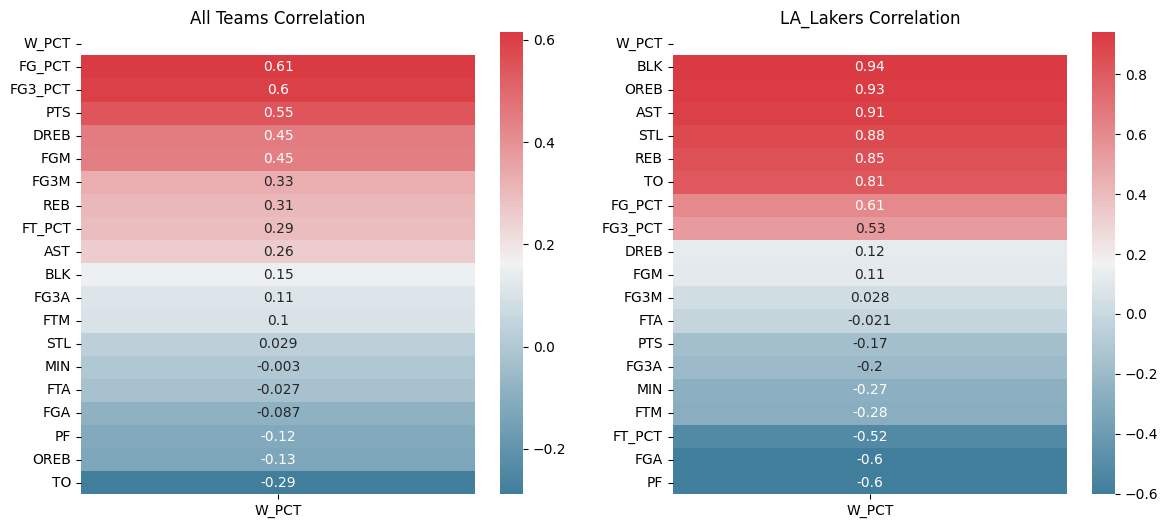

In [339]:
#시각화를 위한 코딩

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(14, 6))

mask = np.zeros_like(corrteam, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230,11, as_cmap=True)
cor1 = sns.heatmap(corrteam, mask=mask, cmap = cmap,ax=axes[0], annot=True)
axes[0].set_title('All Teams Correlation') # 첫 번째 서브플롯 제목 설정

mask = np.zeros_like(corrLA, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230,11, as_cmap=True)
cor2 = sns.heatmap(corrLA, mask=mask, cmap = cmap,ax=axes[1], annot=True)
axes[1].set_title('LA_Lakers Correlation') # 첫 번째 서브플롯 제목 설정

plt.show()

In [340]:
#comment 테이블 만들기 (gmaes_details 기반)

cmt_name=wj_games_details[['PLAYER_ID','PLAYER_NAME','COMMENT']].sort_values(by=['PLAYER_NAME','COMMENT'],ascending=False)
cmt_name

,PLAYER_ID,PLAYER_NAME,COMMENT
87329,1629597,Zylan Cheatham,DNP - Coach's Decision
89398,1629597,Zylan Cheatham,DNP - Coach's Decision
98973,1629597,Zylan Cheatham,DNP - Coach's Decision
99805,1629597,Zylan Cheatham,DNP - Coach's Decision
406033,1629597,Zylan Cheatham,DNP - Coach's Decision
...,...,...,...
12800,1630639,A.J. Lawson,NaN
13867,1630639,A.J. Lawson,NaN
14140,1630639,A.J. Lawson,NaN
50700,1630639,A.J. Lawson,NaN


In [341]:
#결측값 제거 후 표준화해주기
#표준화가 필요한 데이터셋 (stat_2019~2022, LAL_2019~2022)

#sklearn 가져오기. (표준화에 필요한 라이브러리)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#표준화 작업
sk19 = scaler.fit_transform(stat_2019.loc[:,'FGM':'PTS'])
sk19 = scaler.fit_transform(sk19)
sk19 = pd.DataFrame(sk19,columns=stat_2019.loc[:,'FGM':'PTS'].columns)
stat_2019.loc[:,'FGM':'PTS'] = sk19
stat_2019

,SEASON,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS
0,2019,240.016667,0.941785,1.601613,0.432593,0.915055,1.582084,0.820213,-1.448477,-0.719566,-1.489881,-1.027138,2.068025,1.146237,1.318823,-0.276456,1.873804,-0.702082,1.419620,0.314656
1,2019,264.983333,-0.036751,0.869929,-0.733787,1.173437,2.664981,-0.435369,1.349620,1.475579,0.452298,-1.304105,1.149843,0.235681,-0.492790,0.075914,-0.432144,1.073876,2.550937,1.050612
2,2019,240.0,1.333200,0.577255,1.052298,1.173437,0.499187,1.468631,-0.360328,0.055191,0.244320,-0.473205,1.149843,0.690959,0.916242,0.428284,0.720830,-0.448374,-1.295540,1.295930
3,2019,240.0,-0.623873,-0.886113,-0.191284,0.398290,1.446722,0.301902,-0.515778,0.055191,-1.183054,-1.304105,0.782570,-0.067837,-0.694081,-1.685937,-0.432144,0.312751,0.062040,-0.666618
4,2019,240.0,1.137492,0.723592,1.753378,1.173437,1.717446,2.362453,-0.982128,-0.719566,-1.609290,0.357696,2.068025,1.905033,-0.090210,1.133024,-0.432144,-0.194666,-0.390487,0.805293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863,2019,240.0,-0.623873,-0.593440,-0.553300,1.431820,1.446722,-0.504125,1.815969,1.217327,1.176661,0.357696,-0.135612,0.083922,0.111081,-0.981197,-0.432144,0.820167,0.514567,0.887066
864,2019,240.0,-0.623873,0.430918,-0.286222,0.915055,0.363825,1.978480,0.106021,0.055191,0.491046,0.080729,0.598934,0.539200,0.111081,0.075914,-0.432144,0.312751,-0.390487,-0.175981
865,2019,290.0,1.137492,2.479634,0.121698,2.465350,2.800343,0.314595,-0.360328,-0.203061,-0.320303,1.465563,0.048025,0.842718,1.922694,-0.628826,-0.432144,2.088708,2.098410,1.541249
866,2019,240.0,-0.428166,-0.886113,2.018369,2.206967,1.582084,2.740080,-0.515778,-0.461314,-0.229363,0.357696,-1.604703,-1.130152,0.714952,-0.981197,0.336505,-0.448374,-0.390487,0.069337


Text(0.5, 1.0, 'Efficiency Correlaion')

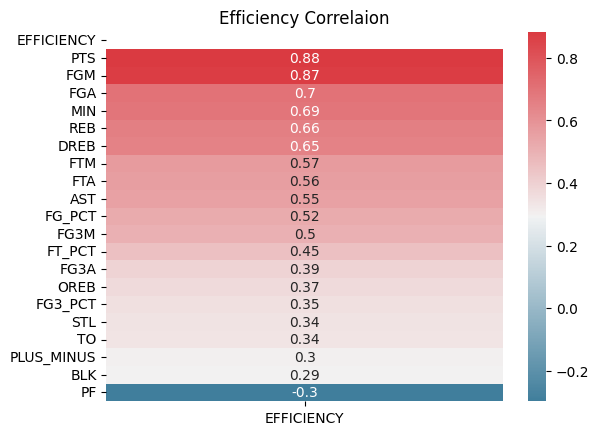

In [342]:
#Efficiency

mask = np.zeros_like(corr_eff, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230,11, as_cmap=True)
cor1 = sns.heatmap(corr_eff, mask=mask, cmap = cmap, annot=True)
cor1.set_title('Efficiency Correlaion') # 첫 번째 서브플롯 제목 설정

In [343]:
lakers22 = LA_lakers[LA_lakers['SEASON']==2022].copy()
#lakers22 = lakers22.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
#                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS'
#                        ]].mean()
lakers22

,PLAYER_ID,PLAYER_NAME,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,SEASON,EFFICIENCY
275,1629022,Lonnie Walker IV,36:25,6.0,13.0,0.462,3.0,6.0,0.500,4.0,4.0,1.000,0.0,5.0,5.0,1.0,2.0,1.0,2.0,3.0,19.0,-15.0,2022,19.0
276,2544,LeBron James,34:00,11.0,21.0,0.524,0.0,4.0,0.000,9.0,10.0,0.900,0.0,6.0,6.0,11.0,0.0,2.0,2.0,0.0,31.0,-4.0,2022,37.0
277,1628418,Thomas Bryant,28:30,6.0,9.0,0.667,2.0,2.0,1.000,3.0,4.0,0.750,2.0,8.0,10.0,4.0,1.0,0.0,2.0,5.0,17.0,-13.0,2022,26.0
278,201976,Patrick Beverley,37:15,5.0,7.0,0.714,1.0,2.0,0.500,2.0,2.0,1.000,0.0,2.0,2.0,3.0,3.0,1.0,3.0,3.0,13.0,-15.0,2022,17.0
279,203471,Dennis Schroder,29:54,6.0,13.0,0.462,2.0,4.0,0.500,4.0,6.0,0.667,0.0,1.0,1.0,3.0,0.0,0.0,2.0,4.0,18.0,-8.0,2022,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12173,1630346,Matt Ryan,17:49,1.0,4.0,0.250,1.0,3.0,0.333,0.0,0.0,0.000,0.0,1.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,1.0,2022,1.0
12174,1631306,Cole Swider,1:52,0.0,1.0,0.000,0.0,1.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2022,1.0
12175,1630590,Scotty Pippen Jr.,1:52,0.0,0.0,0.000,0.0,0.0,0.000,2.0,2.0,1.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2022,2.0
12176,1631108,Max Christie,1:52,1.0,1.0,1.000,1.0,1.0,1.000,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2022,4.0


In [344]:
lakers21 = LA_lakers[LA_lakers['SEASON']==2021].copy()
lakers21['EFFICIENCY'] = ((
    lakers21['PTS'] +
    lakers21['REB'] +
    lakers21['AST'] +
    lakers21['STL'] +
    lakers21['BLK']
    ) - (
        (lakers21['FGA'] - lakers21['FGM']) +
        (lakers21['FTA'] - lakers21['FTM']) +
        lakers21['TO']
    ))

lakers21 = lakers21.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[[
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','EFFICIENCY'
                        ]].mean().reset_index()

lakers21

#

,PLAYER_ID,PLAYER_NAME,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,EFFICIENCY
0,2544,LeBron James,2021,11.428571,21.803571,0.523964,2.875000,8.000000,0.355589,4.535714,6.000000,0.765089,1.125000,7.071429,8.196429,6.232143,1.303571,1.053571,3.500000,2.160714,30.267857,31.714286
1,2546,Carmelo Anthony,2021,4.623188,10.478261,0.435101,2.159420,5.753623,0.354565,1.913043,2.304348,0.596391,0.898551,3.275362,4.173913,0.985507,0.681159,0.753623,0.855072,2.405797,13.318841,12.811594
2,2730,Dwight Howard,2021,2.233333,3.650000,0.553100,0.133333,0.250000,0.105550,1.600000,2.433333,0.481767,1.966667,3.966667,5.933333,0.583333,0.566667,0.600000,0.783333,1.916667,6.200000,10.850000
3,2772,Trevor Ariza,2021,1.375000,4.125000,0.368917,0.833333,3.083333,0.297292,0.416667,0.750000,0.197917,0.416667,3.000000,3.416667,1.125000,0.541667,0.250000,0.458333,0.833333,4.000000,5.791667
4,200765,Rajon Rondo,2021,1.277778,3.944444,0.286944,0.444444,1.666667,0.152778,0.055556,0.111111,0.027778,0.611111,2.166667,2.777778,3.722222,0.666667,0.277778,1.888889,1.388889,3.055556,5.888889
5,201566,Russell Westbrook,2021,7.025641,15.807692,0.438385,1.012821,3.397436,0.260628,3.410256,5.115385,0.585269,1.410256,6.025641,7.435897,7.051282,0.961538,0.256410,3.782051,3.012821,18.474359,19.910256
6,201571,D.J. Augustin,2021,1.857143,4.095238,0.377000,1.380952,3.238095,0.356524,0.238095,0.238095,0.142857,0.190476,1.095238,1.285714,1.571429,0.333333,0.047619,0.523810,1.047619,5.333333,5.809524
7,201599,DeAndre Jordan,2021,1.875000,2.781250,0.590656,0.000000,0.000000,0.000000,0.375000,0.812500,0.179688,1.593750,3.781250,5.375000,0.406250,0.312500,0.812500,0.656250,1.562500,4.125000,9.031250
8,201954,Darren Collison,2021,0.666667,2.333333,0.333333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.333333,1.333333,0.666667,0.333333,0.000000,0.333333,1.666667,1.333333,1.666667
9,201961,Wayne Ellington,2021,2.279070,5.511628,0.430023,1.906977,4.906977,0.420465,0.209302,0.255814,0.110465,0.232558,1.558140,1.790698,0.697674,0.534884,0.116279,0.441860,0.976744,6.674419,6.093023


In [345]:
LA_lakers = LA_lakers.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[[
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','EFFICIENCY'
                        ]].mean()
LA_lakers = LA_lakers.reset_index()
LA_lakers.drop(columns=['PLAYER_ID','PLAYER_NAME','SEASON']).median()

,0
FGM,2.357143
FGA,5.105263
FG_PCT,0.413103
FG3M,0.807692
FG3A,2.346154
FG3_PCT,0.254167
FTM,0.844828
FTA,1.090909
FT_PCT,0.312638
OREB,0.550725


In [346]:
#MaxChristie
# MaxChrisie
# Scal_MaxChrisite -> 정규화 Max_Christie
MaxChristie = eff[eff['PLAYER_NAME']=='Max Christie'].copy()
MaxChristie= MaxChristie.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean()
scaleff = scaler.fit_transform(eff.loc[:,'FGM':'PTS'])
scaleff = scaler.fit_transform(scaleff)
scaleff = pd.DataFrame(scaleff,columns=eff.loc[:,'FGM':'PTS'].columns)
scaleff.loc[:,'FGM':'PTS'] = scaleff
Scaleff = eff.copy()
Scaleff.loc[:,'FGM':'PTS'] = scaleff
#Scaleff -> 전체 선수의 정규화 값 ( Min, Efficiency )
Scaleff = Scaleff.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean()
Scaleff = Scaleff.reset_index()
Scaleff[Scaleff['PLAYER_NAME']=='Max Christie']
#cmt_name[cmt_name['PLAYER_NAME']=='Max Christie'].sort_values(by='COMMENT', ascending=False)
#Kendrick Nunn
KendrickNunn = eff[eff['PLAYER_NAME']=='Kendrick Nunn'].copy()
KendrickNunn= KendrickNunn.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean()
#정규화된 선수 수치 찾기
Scaleff[Scaleff['PLAYER_NAME']=='Kendrick Nunn']
#코멘트 찾기
#Numm_cmt = cmt_name[cmt_name['PLAYER_NAME']=='Kendrick Nunn'].sort_values(by='COMMENT', ascending=False)
#umm_cmt = cmt_name[(cmt_name['PLAYER_NAME']=='Kendrick Nunn')&(cmt_name['COMMENT'] != '')].sort_values(by='COMMENT', ascending=False)
#Numm_cmt
#선수 영입
#테이블
#gpmean 각 시즌 필요 스탯별 평균 수치
#gpeff 각 시즌별 선수 스탯
gpeff = eff.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean()
gpeff = gpeff
#gpeff.sort_values(by='EFFICIENCY',ascending=False)
gpeff = gpeff.reset_index()
gpmean = gpeff.drop(columns=['PLAYER_ID', 'PLAYER_NAME'],inplace=False)
gpmean = gpmean.groupby(['SEASON'])[['MIN',
                        'FG3M','FG3_PCT','OREB','DREB','REB','STL','BLK','PTS','EFFICIENCY'
                        ]].mean()
#선수 필터링
#0.73 , 0.52
#gpeff = gpeff.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
#                        'FG3M','FG3A','FG3_PCT','OREB','DREB','REB','STL','BLK','PTS','PLUS_MINUS','EFFICIENCY'
#                        ]].mean()
#pd.set_option('display.max_rows',None)
#선수 필터링
filnba = gpeff[~(gpeff['PLAYER_NAME'].isin(['Giannis Antetokounmpo', 'Nikola Jokic', 'Stephen Curry', 'Kevin Durant', 'LeBron James', 'Luka Doncic', 'Joel Embiid', 'James Harden', 'Kawhi Leonard', 'Damian Lillard']))]
filnba = filnba[(filnba['STL']>=0.73)&(filnba['BLK']>=0.5)&(filnba['MIN']>=10)&(filnba['EFFICIENCY']>=12)]
filnba = filnba[filnba['SEASON']==2021]
filnba2 = filnba.groupby(['PLAYER_ID', 'PLAYER_NAME','SEASON'])[['EFFICIENCY','STL','BLK',
                        'FG3M','FG3_PCT','REB','OREB','DREB','PTS','MIN'
                        ]].mean()
filnba2.sort_values(by='EFFICIENCY',ascending=False)
#
# 2명을 뽑을건데
#1. STL 1명, BLK 1명
#2. 둘다 수준급 1명, 3점슛 1명
#3. 둘다 수준급 2명
#4. 둘 다 수준급 1명, 올라운더 1명(백업용 ->STL BLK 어느정도 하면서 공격수치가 어느정도 되는)
#둘다 수준급
#Robert Covington (1.4 1.2 12)
#Anthony Davis (1.2 2.2 27)
#Draymond Green (1.3 1.0 17)
#Nikola Vucevic(0.9 0.9 23)
#올라운더
#Kyrie Lrvbing (3점슛 3.4 , 스틸 1.4 , EFF 25)
#Bobby Portis (3점슛 1.8 , 리바운드 9.1, OREB 2.5, EFF 18)
#Steven Adams (OREB 4.5 , 리바운드 10, 3점슛 X, EFF 16)

#1. 기준을 세운 이유와 기준이 되는 스탯
#ppt 16p를 통해 팀의 색이 수비형 팀임을 설명 + BLK와 STL  감
#ppt 18p에서 승률과 상관관계 높은 스탯들 중 팀에서 크게 감소한 STL, BLK를 우선순위로 선정
#선수들의 여러 능력치들을 종합적으로 합쳐서 만든 EFFICIENCY 라는 스탯을 테이블에 기재
#-> 위의 자료들을 토대로 최우선으로 EFFICIENCY와 STL, BLK를 보기로 결정, 그리고 부가 옵션으로 3점슛을 잘하는 선수가 있으면 좋겠다고 판단
#-> 필터링 설정
#시즌별 NBA선수들의 평균능력치와 LA_LAKERS의 평균 능력치들을 기준을 보고 위에서 선정한 세가지 스탯을 평균보다 약간 높은 수치로 임의 설정
#평균값 (STL 0.6 ~ 0.62 선정값 0.73, BLK 0.36~0.41 선정값 0.52, EFF 9.4~10.2 선정값 12) + 경기당 참가 시간 10분이상 으로 선정
#-> 테이블 정렬 (STL, BLK, EFFICIENCY 등을 기준으로 정렬)
#*탑플레이어는 영입이 너무 어려울 것으로 제외해 테이블에서 제외 후 검색
#*이전시즌까지 잘한 선수가 필요하기 때문에 21시즌 성적 검색
#STL과 BLK가 모두 1이 넘는 선수를 찾아 나온 Robert Covington
#EFFCIENCY를 기준으로 찾다가 나온 선수 Nikola Vucevic
#(* STL이나 BLK 한쪽으로 1이 넘는 수치는 아니지만 양 스탯이 모두 0.9 이상이고 다른 스탯들을 보니 리바운드나 3점슛 등 전체적으로 양호한 팀에 필요한 올라운더 선수라 판단)

#EFF

#2. 눈여겨본 스탯들을 보기 쉽게 정리한 테이블
LA_lakers


,PLAYER_ID,PLAYER_NAME,SEASON,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,EFFICIENCY
0,2544,LeBron James,2019,9.597015,19.447761,0.489612,2.208955,6.343284,0.324254,3.940299,5.686567,0.681209,0.985075,6.850746,7.835821,10.208955,1.164179,0.537313,3.895522,1.761194,25.343284,29.597015
1,2544,LeBron James,2020,9.413043,18.391304,0.508913,2.282609,6.260870,0.346239,3.934783,5.652174,0.691804,0.630435,7.000000,7.630435,7.782609,1.065217,0.565217,3.695652,1.543478,25.043478,27.695652
2,2544,LeBron James,2021,11.428571,21.803571,0.523964,2.875000,8.000000,0.355589,4.535714,6.000000,0.765089,1.125000,7.071429,8.196429,6.232143,1.303571,1.053571,3.500000,2.160714,30.267857,31.714286
3,2544,LeBron James,2022,10.652174,21.913043,0.486130,2.130435,7.000000,0.283304,3.695652,5.086957,0.676348,1.347826,7.086957,8.434783,6.652174,1.173913,0.652174,3.043478,1.826087,27.130435,28.347826
4,2546,Carmelo Anthony,2021,4.623188,10.478261,0.435101,2.159420,5.753623,0.354565,1.913043,2.304348,0.596391,0.898551,3.275362,4.173913,0.985507,0.681159,0.753623,0.855072,2.405797,13.318841,12.811594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,1630602,Chaundee Brown Jr.,2021,0.500000,3.500000,0.500000,0.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.000000,1.000000,-1.500000
79,1630643,Jay Huff,2021,0.000000,0.750000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.750000,1.000000,0.250000,0.250000,0.250000,0.250000,0.250000,0.000000,0.750000
80,1630644,Mac McClung,2021,2.000000,5.000000,0.400000,1.000000,3.000000,0.333000,1.000000,1.000000,1.000000,0.000000,3.000000,3.000000,1.000000,1.000000,1.000000,2.000000,5.000000,6.000000,7.000000
81,1631108,Max Christie,2022,1.266667,3.400000,0.404933,0.933333,2.133333,0.366667,0.200000,0.266667,0.100000,0.333333,2.466667,2.800000,0.600000,0.200000,0.133333,0.266667,0.600000,3.666667,4.933333


In [357]:
#정규화
#Scaleff가 정규화된 선수들의 데이터

season_column = eff.pop('SEASON')
eff.insert(0, 'SEASON', season_column)

scaleff2 = scaler.fit_transform(eff.loc[:,'FGM':'EFFICIENCY'])
scaleff2 = scaler.fit_transform(scaleff2)
scaleff2 = pd.DataFrame(scaleff2,columns=eff.loc[:,'FGM':'EFFICIENCY'].columns)
scaleff2.loc[:,'FGM':'EFFICIENCY'] = scaleff2
Scaleff = eff.copy()
Scaleff.loc[:,'FGM':'EFFICIENCY'] = scaleff2

#조건출력
Scaleff=Scaleff.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean()
Scaleff=Scaleff.reset_index()

#르브론 제임스 뽑기
#Lebron21 = Scaleff[(Scaleff['PLAYER_NAME']=='LeBron James')&(Scaleff['SEASON']==2021)].copy()
#Lebron21
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
#pd.reset_option('display')
Scaleff[Scaleff['SEASON']==2021].sort_values(by='EFFICIENCY',ascending=False)

,PLAYER_ID,PLAYER_NAME,SEASON,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,EFFICIENCY
38,101141,Ersan Ilyasova,2021,NaN,1.142994,0.451226,1.166428,0.223387,-0.583652,0.834186,-0.710916,-0.760841,-0.984209,1.540046,2.645903,2.696086,-0.125375,-0.225859,1.287227,-0.191830,-0.598038,0.693078,0.485526,1.790431
1140,1628537,Jaylen Morris,2021,5.344444,1.613451,1.801098,0.164388,1.463359,1.238197,0.704413,1.027679,1.043154,0.819723,-0.467723,1.129866,0.718797,2.084001,1.002449,2.312104,3.121508,-0.371729,1.716289,-0.440935,1.535016
35,101139,CJ Miles,2021,1.95,0.829357,0.198125,0.687365,-0.791135,-0.583652,-0.888472,0.158382,0.141157,-0.063052,0.410676,2.282054,1.972688,0.849350,-0.225859,0.057375,-0.191830,1.438737,0.519325,0.529643,1.535016
1691,1629689,Aric Holman,2021,NaN,0.358901,-0.054975,0.775193,-0.791135,-1.080521,-0.888472,-0.710916,-0.760841,-0.984209,3.798785,2.100130,3.130125,0.264515,0.300559,0.672301,-0.191830,1.438737,-0.059851,0.264940,1.432851
2125,1630695,Micah Potter,2021,10.311111,1.299813,0.999612,0.567599,0.899736,0.824141,0.305330,1.136342,1.584353,0.187963,0.598904,0.644734,0.742911,0.751877,-0.752277,0.057375,0.163170,-0.088844,1.417048,0.353174,1.254061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,1629713,Justin James,2021,NaN,-0.974058,-0.983012,-0.556202,-0.791135,-0.832086,-0.888472,-0.058943,0.321556,-0.264555,0.034220,-0.537775,-0.414527,-0.905154,0.037350,0.364838,-0.724331,0.420350,-0.870697,-0.418876,-0.840336
953,1628221,Gabe York,2021,10.65,-1.209286,-1.067379,-1.719926,-0.791135,-0.749275,-0.888472,-0.710916,-0.760841,-0.984209,-0.718694,-0.082964,-0.342187,0.654405,-0.752277,-0.557551,0.518171,0.759812,-1.218203,0.264940,-0.916960
1970,1630285,Zavier Simpson,2021,43.520833,-0.817239,-0.729911,-1.265814,-0.452961,-0.418030,-0.543941,-0.384930,-0.400042,-0.552417,-0.530465,-0.719699,-0.776226,-0.320319,-0.489068,-0.250088,-0.014330,-0.767769,-0.783821,-0.308583,-0.916960
2033,1630554,Jason Preston,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [369]:
Lebron21 = Scaleff[(Scaleff['PLAYER_NAME']=='LeBron James')&(Scaleff['SEASON']==2021)].copy()
Lebron22 = Scaleff[(Scaleff['PLAYER_NAME']=='LeBron James')&(Scaleff['SEASON']==2022)].copy()
Lebron=pd.concat([Lebron21,Lebron22])
Lebron['SEASON']=2022
Lebron = Lebron.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean().reset_index()
Lebron

,PLAYER_ID,PLAYER_NAME,SEASON,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,EFFICIENCY
0,2544,LeBron James,2022,36.691214,1.008439,1.077503,0.039261,0.322709,0.585847,0.049495,0.420444,0.517643,0.345101,0.126747,0.719958,0.621274,0.785521,0.252448,0.232522,0.55534,-0.068211,0.912209,-0.003325,0.821987


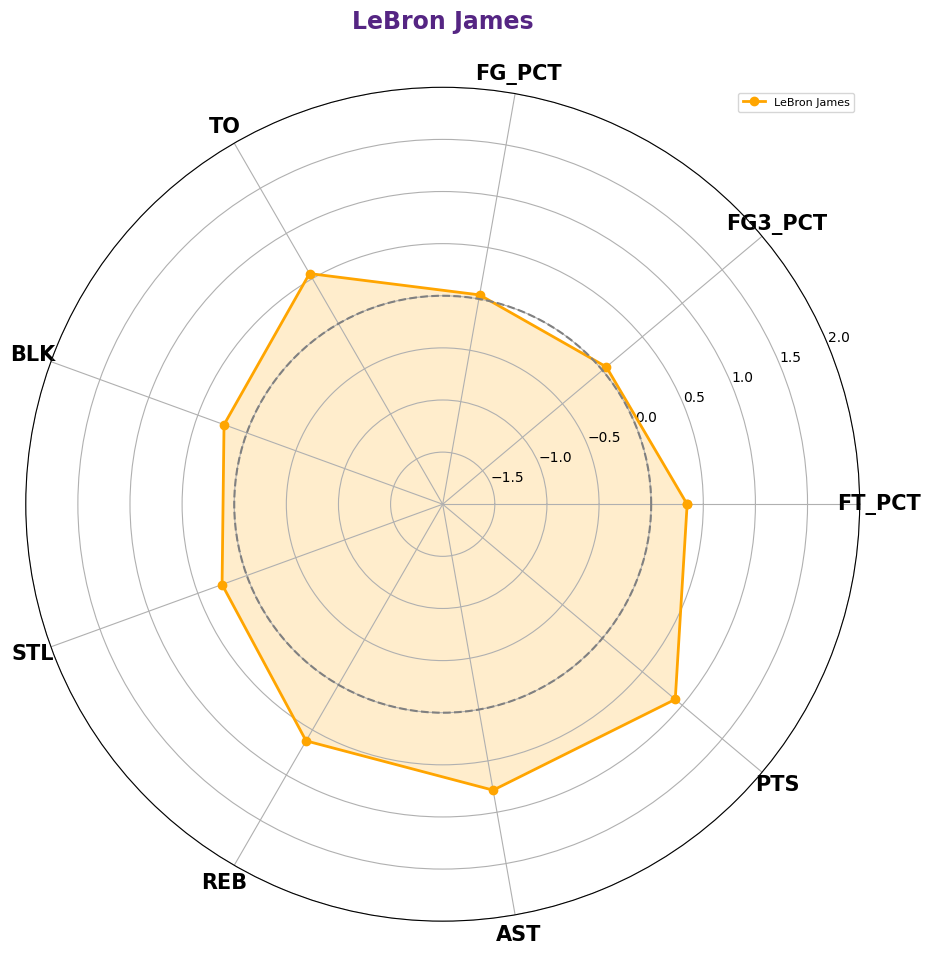

In [370]:
seasons = ['2022'] # 이 리스트의 첫 번째 시즌을 사용할 것입니다.
kpi_metrics = ['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS']

# 'SEASON' 컬럼을 문자열로 통일 (Scaleff에 직접 적용)
Lebron['SEASON'] = Lebron['SEASON'].astype(str)

# # LeBron James 정규화 수치 (Scaleff에서 LeBron James 데이터 추출)
Lebron = Lebron.loc[Lebron['PLAYER_NAME'] == 'LeBron James', ['SEASON']+kpi_metrics]

# 방사형 좌표 설정
angles = np.linspace(0, 2 * np.pi, len(kpi_metrics), endpoint=False).tolist()
angles += angles[:1]

# 그래프 그리기 (하나의 레이더 차트만 출력)
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))

# 단일 시즌 선택 (여기서는 '2021' 시즌을 가정)
target_season_for_plot = seasons[0]

# --- 문제의 ds_vals 생성 부분 ---
ds_vals = Lebron.loc[Lebron['SEASON'] == target_season_for_plot, kpi_metrics].values.flatten().tolist()

# --- 이 부분이 오류가 나는 부분입니다. ds_vals가 비어있을 때 발생합니다. ---
ds_vals += [ds_vals[0]] # 차트 닫기

ax.plot(angles, ds_vals, marker='o', linewidth=2, color='orange', label='LeBron James')
ax.fill(angles, ds_vals, color='orange',alpha=0.2)


#ax.set_title(f'Season {target_season_for_plot}', size=15, pad=40)
ax.set_thetagrids(np.degrees(angles[:-1]), kpi_metrics, fontsize=15, weight='bold')
ax.set_ylim(-2.0, 2)
ax.axhline(0, color='Gray',alpha=1, linestyle='--', linewidth=1.5)
ax.legend(loc='upper right', fontsize=8)

plt.suptitle(
    'LeBron James',
    fontsize=17, weight='bold', color='#552583' , y = 0.95
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [379]:
Anthony21 = Scaleff[(Scaleff['PLAYER_NAME']=='Anthony Davis')&(Scaleff['SEASON']==2021)].copy()
Anthony22 = Scaleff[(Scaleff['PLAYER_NAME']=='Anthony Davis')&(Scaleff['SEASON']==2022)].copy()
Anthony=pd.concat([Anthony21,Anthony22])
Anthony['SEASON']=2022
Anthony = Anthony.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean().reset_index()
Anthony

,PLAYER_ID,PLAYER_NAME,SEASON,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,EFFICIENCY
0,203076,Anthony Davis,2022,34.268333,1.008827,0.750635,0.315437,-0.331218,-0.419686,-0.267839,1.251282,1.235781,0.497018,0.790479,1.112482,1.188524,0.026466,0.29354,1.087717,0.327654,0.278153,1.021921,0.1695,1.217905


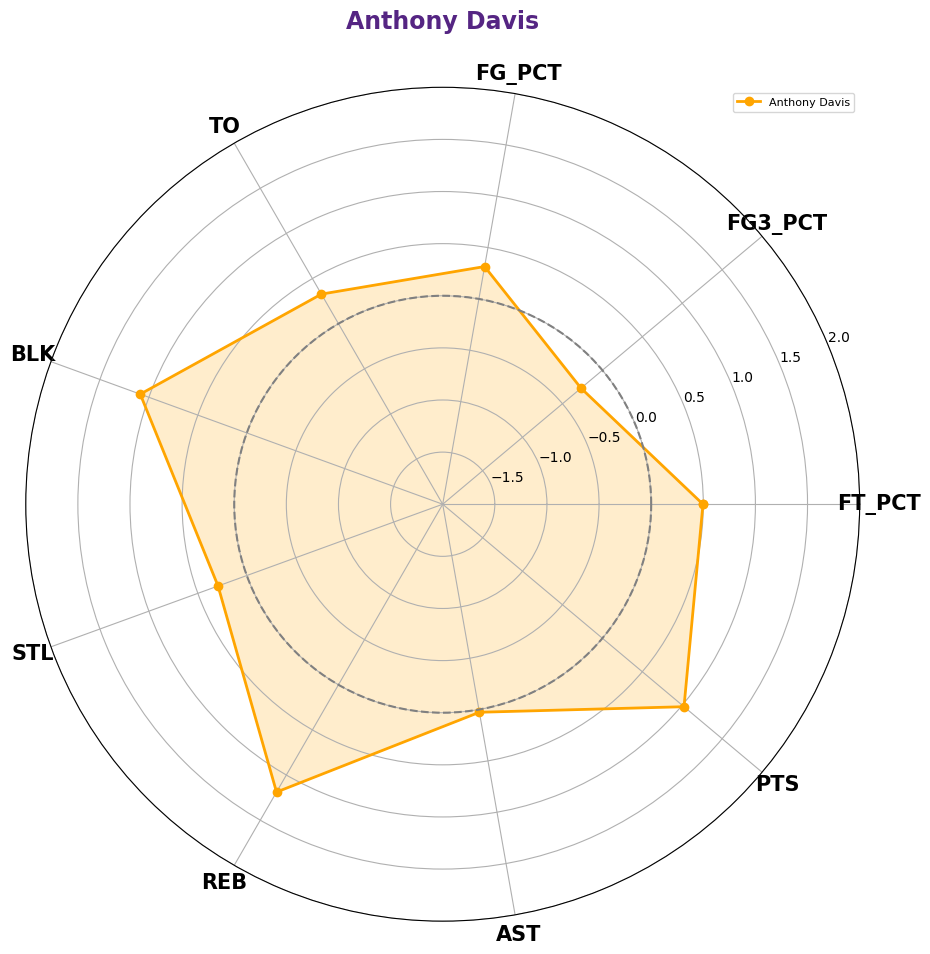

In [380]:
seasons = ['2022'] # 이 리스트의 첫 번째 시즌을 사용할 것입니다.
kpi_metrics = ['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS']

# 'SEASON' 컬럼을 문자열로 통일 (Scaleff에 직접 적용)
Anthony['SEASON'] = Anthony['SEASON'].astype(str)

# # LeBron James 정규화 수치 (Scaleff에서 LeBron James 데이터 추출)
Anthony = Anthony.loc[Anthony['PLAYER_NAME'] == 'Anthony Davis', ['SEASON']+kpi_metrics]

# 방사형 좌표 설정
angles = np.linspace(0, 2 * np.pi, len(kpi_metrics), endpoint=False).tolist()
angles += angles[:1]

# 그래프 그리기 (하나의 레이더 차트만 출력)
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))

# 단일 시즌 선택 (여기서는 '2021' 시즌을 가정)
target_season_for_plot = seasons[0]

# --- 문제의 ds_vals 생성 부분 ---
ds_vals = Anthony.loc[Lebron['SEASON'] == target_season_for_plot, kpi_metrics].values.flatten().tolist()

# --- 이 부분이 오류가 나는 부분입니다. ds_vals가 비어있을 때 발생합니다. ---
ds_vals += [ds_vals[0]] # 차트 닫기

ax.plot(angles, ds_vals, marker='o', linewidth=2, color='orange', label='Anthony Davis')
ax.fill(angles, ds_vals, color='orange',alpha=0.2)


#ax.set_title(f'Season {target_season_for_plot}', size=15, pad=40)
ax.set_thetagrids(np.degrees(angles[:-1]), kpi_metrics, fontsize=15, weight='bold')
ax.set_ylim(-2.0, 2)
ax.axhline(0, color='Gray',alpha=1, linestyle='--', linewidth=1.5)
ax.legend(loc='upper right', fontsize=8)

plt.suptitle(
    'Anthony Davis',
    fontsize=17, weight='bold', color='#552583' , y = 0.95
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [432]:
Patrick21 = Scaleff[(Scaleff['PLAYER_NAME']=='Patrick Beverley')&(Scaleff['SEASON']==2021)].copy()
Patrick22 = Scaleff[(Scaleff['PLAYER_NAME']=='Patrick Beverley')&(Scaleff['SEASON']==2022)].copy()
Patrick=pd.concat([Patrick21,Patrick22])
Patrick = Patrick.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean().reset_index()
Patrick21=Patrick[Patrick['SEASON']==2021][['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']]
Patrick22=Patrick[Patrick['SEASON']==2022][['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']]
Patrick22

,FT_PCT,FG3_PCT,FG_PCT,TO,BLK,STL,REB,AST,PTS,EFFICIENCY
1,-0.120624,0.128327,-0.285066,-0.162247,0.057375,0.212822,-0.18545,0.102061,-0.600415,-0.367819


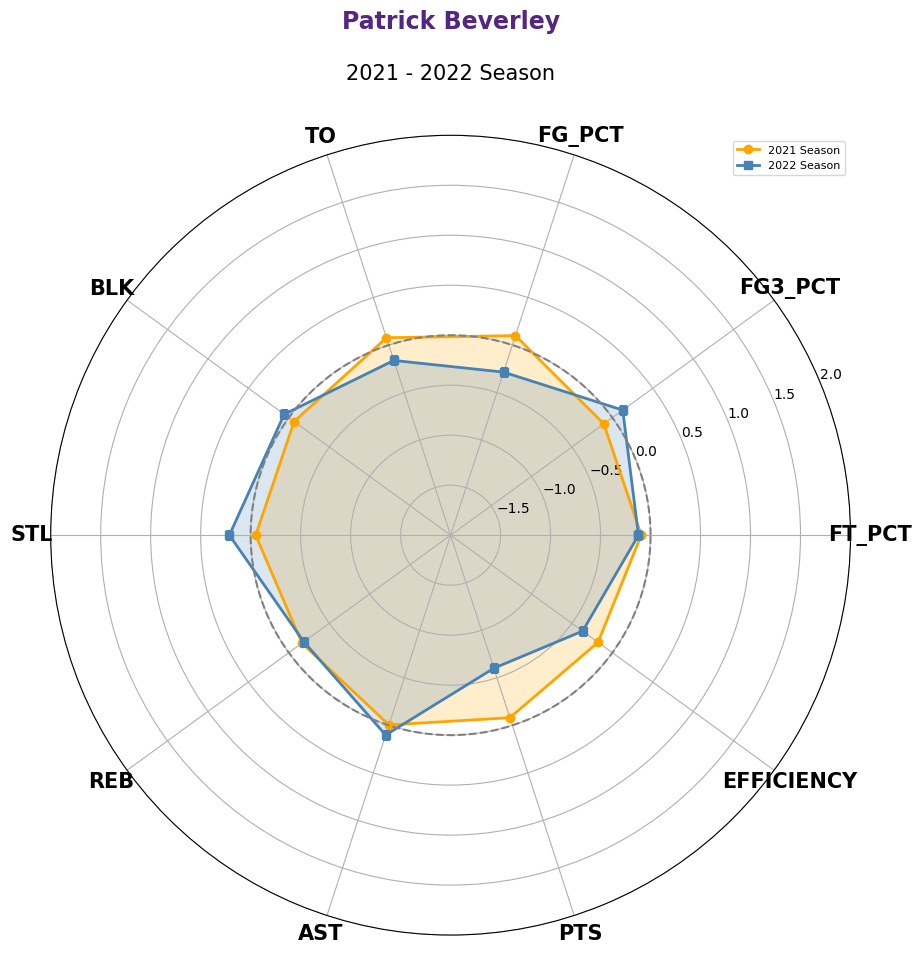

In [433]:
kpi_metrics = ['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']
# 방사형 좌표 설정
angles = np.linspace(0, 2 * np.pi, len(kpi_metrics), endpoint=False).tolist()
angles += angles[:1]
# 그래프 그리기 (하나의 레이더 차트만 출력)
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))
# 단일 시즌 선택 (여기서는 '2021' 시즌을 가정)
# target_season_for_plot = seasons[0]
nk_vals = Patrick21[kpi_metrics].values.flatten().tolist()
l4_vals = Patrick22[kpi_metrics].values.flatten().tolist()
# --- 이 부분이 오류가 나는 부분입니다. ds_vals가 비어있을 때 발생합니다. ---
nk_vals += [nk_vals[0]] # 차트 닫기
l4_vals += [l4_vals[0]]
ax.plot(angles, nk_vals, marker='o', linewidth=2, color='orange', label='2021 Season')
ax.plot(angles, l4_vals, marker='s', linewidth=2, color='steelblue', label='2022 Season')
ax.fill(angles, nk_vals, color='orange',alpha=0.2)
ax.fill(angles, l4_vals, color='steelblue',alpha=0.2)
ax.set_title(f'2021 - 2022 Season', size=15, pad=40)
ax.set_thetagrids(np.degrees(angles[:-1]), kpi_metrics, fontsize=15, weight='bold')
ax.set_ylim(-2.0, 2)
ax.axhline(0, color='Gray', linestyle='--', linewidth=1.5)
ax.legend(loc='upper right', fontsize=8)
plt.suptitle(
    'Patrick Beverley',
    fontsize=17, weight='bold', color='#552583' , y = 0.95
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [439]:
Kendrick21 = Scaleff[(Scaleff['PLAYER_NAME']=='Kendrick Nunn')&(Scaleff['SEASON']==2020)].copy()
Kendrick22 = Scaleff[(Scaleff['PLAYER_NAME']=='Kendrick Nunn')&(Scaleff['SEASON']==2022)].copy()
Kendrick=pd.concat([Kendrick21,Kendrick22])
Kendrick = Kendrick.groupby(['PLAYER_ID','PLAYER_NAME','SEASON'])[['MIN',
                        'FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT','FTM','FTA','FT_PCT','OREB','DREB','REB','AST','STL','BLK','TO','PF','PTS','PLUS_MINUS','EFFICIENCY'
                        ]].mean().reset_index()
Kendrick20=Kendrick[Kendrick['SEASON']==2020][['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']]
Kendrick22=Kendrick[Kendrick['SEASON']==2022][['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']]

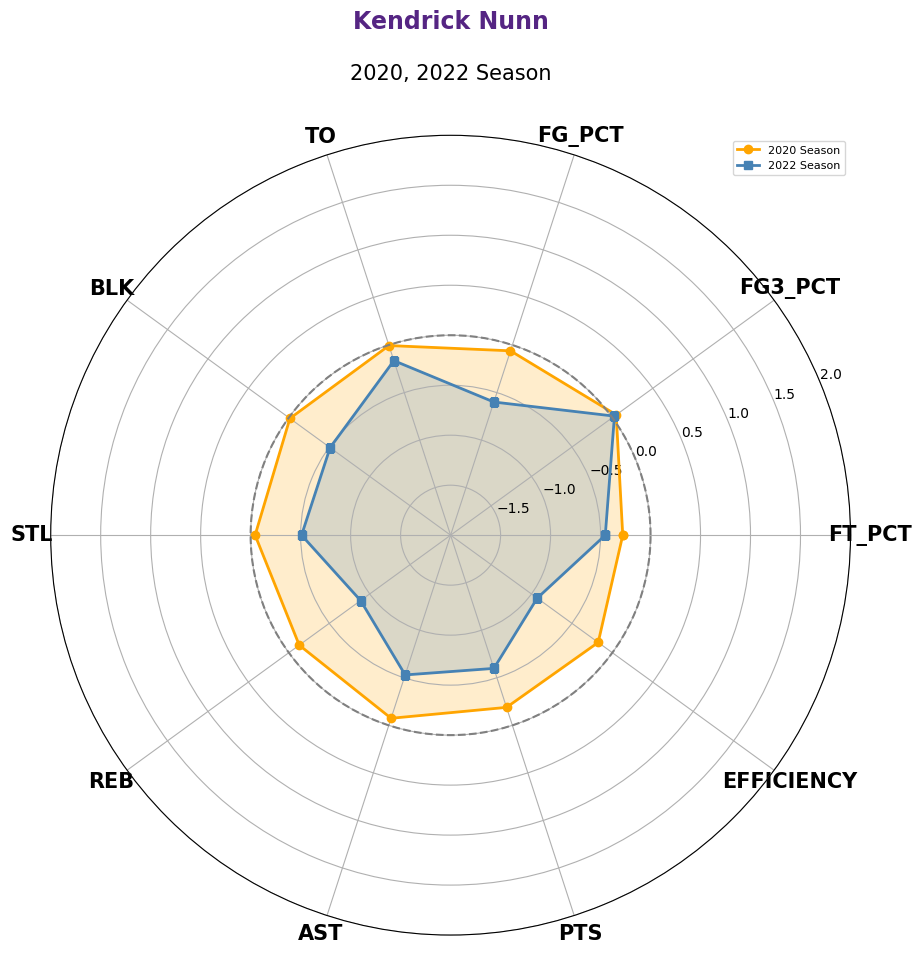

In [441]:
kpi_metrics = ['FT_PCT','FG3_PCT','FG_PCT','TO','BLK','STL','REB','AST','PTS','EFFICIENCY']
# 방사형 좌표 설정
angles = np.linspace(0, 2 * np.pi, len(kpi_metrics), endpoint=False).tolist()
angles += angles[:1]
# 그래프 그리기 (하나의 레이더 차트만 출력)
fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))
# 단일 시즌 선택 (여기서는 '2021' 시즌을 가정)
# target_season_for_plot = seasons[0]
nk_vals = Kendrick20[kpi_metrics].values.flatten().tolist()
l4_vals = Kendrick22[kpi_metrics].values.flatten().tolist()
# --- 이 부분이 오류가 나는 부분입니다. ds_vals가 비어있을 때 발생합니다. ---
nk_vals += [nk_vals[0]] # 차트 닫기
l4_vals += [l4_vals[0]]
ax.plot(angles, nk_vals, marker='o', linewidth=2, color='orange', label='2020 Season')
ax.plot(angles, l4_vals, marker='s', linewidth=2, color='steelblue', label='2022 Season')
ax.fill(angles, nk_vals, color='orange',alpha=0.2)
ax.fill(angles, l4_vals, color='steelblue',alpha=0.2)
ax.set_title(f'2020, 2022 Season', size=15, pad=40)
ax.set_thetagrids(np.degrees(angles[:-1]), kpi_metrics, fontsize=15, weight='bold')
ax.set_ylim(-2.0, 2)
ax.axhline(0, color='Gray', linestyle='--', linewidth=1.5)
ax.legend(loc='upper right', fontsize=8)
plt.suptitle(
    'Kendrick Nunn',
    fontsize=17, weight='bold', color='#552583' , y = 0.95
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


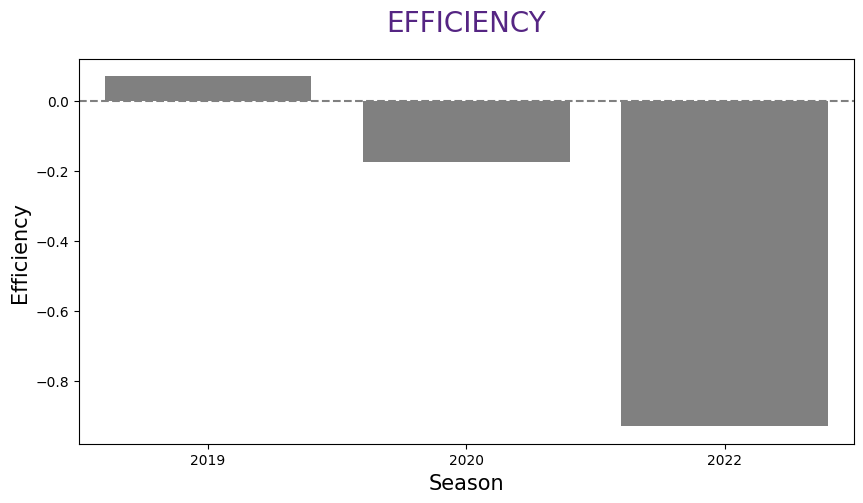

In [487]:
#bar_kendrick = Scaleff[Scaleff['PLAYER_NAME']=='Kendrick Nunn'].copy()
Kendrick19 = Scaleff[(Scaleff['PLAYER_NAME']=='Kendrick Nunn')&(Scaleff['SEASON']==2019)].copy()
bar_Kendrick=pd.concat([Kendrick,Kendrick19])

plt.figure(figsize = (10, 5))
sns.barplot(data=bar_Kendrick, x='SEASON', y='EFFICIENCY',color='Gray')

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

plt.title('EFFICIENCY',fontsize=20,color='#552583',y=1.05) # 그래프 제목 추가 (선택 사항)
plt.xlabel('Season',fontsize=15) # x축 라벨 추가 (선택 사항)
plt.ylabel('Efficiency',fontsize=15) # y축 라벨 추가 (선택 사항)
#plt.legend(title='Player Name') # 범례 제목 추가 (선택 사항)
plt.show()

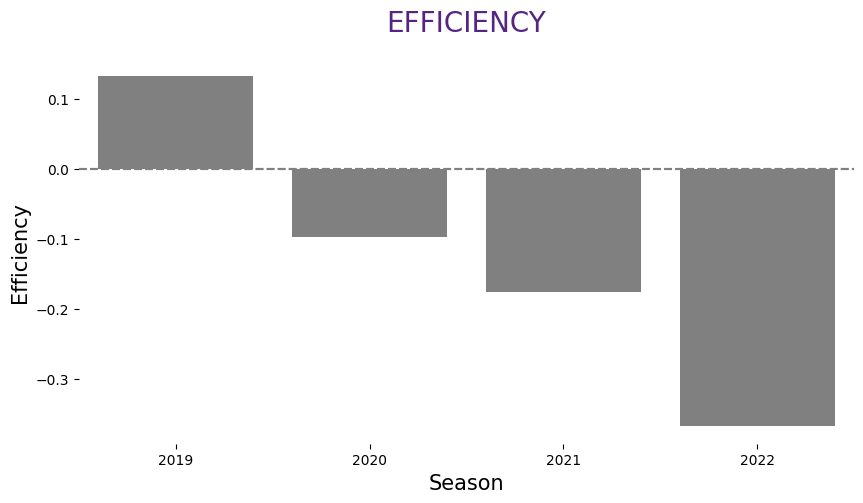

In [488]:
bar_Patrick = Scaleff[Scaleff['PLAYER_NAME']=='Patrick Beverley'].copy()

plt.figure(figsize = (10, 5))

sns.barplot(data=bar_Patrick, x='SEASON', y='EFFICIENCY',color='Gray',alpha=1)
ax = plt.gca() # 현재 Axes 객체를 가져옵니다.
ax.spines['top'].set_visible(False)    # 위쪽 테두리 제거
ax.spines['right'].set_visible(False)  # 오른쪽 테두리 제거
ax.spines['left'].set_visible(False)   # 왼쪽 테두리 제거
ax.spines['bottom'].set_visible(False)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

plt.title('EFFICIENCY',fontsize=20,color='#552583',y=1.05) # 그래프 제목 추가 (선택 사항)
plt.xlabel('Season',fontsize=15) # x축 라벨 추가 (선택 사항)
plt.ylabel('Efficiency',fontsize=15) # y축 라벨 추가 (선택 사항)
plt.show()

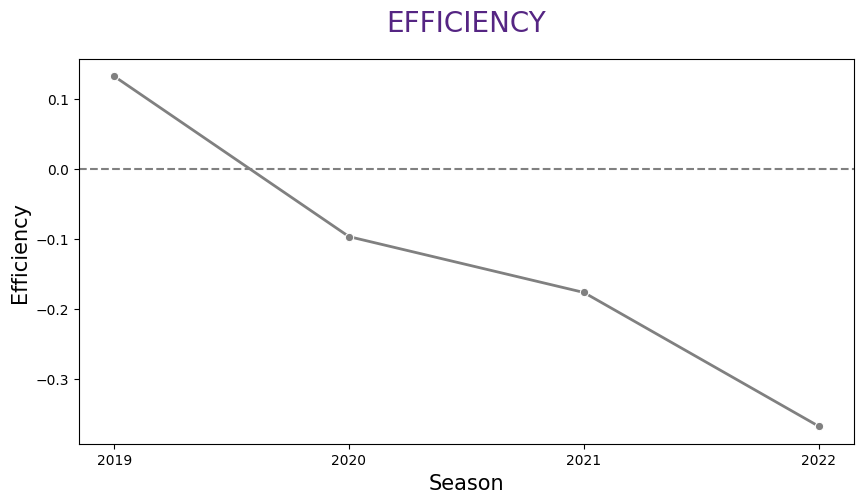

In [495]:
bar_Patrick['SEASON'] = bar_Patrick['SEASON'].astype(int)

plt.figure(figsize = (10, 5))

# sns.barplot 대신 sns.lineplot 사용 (수정된 부분)
# marker='o'를 추가하여 각 데이터 포인트에 점을 표시합니다.
# color와 alpha는 막대 그래프와 동일하게 유지할 수 있습니다.
sns.lineplot(data=bar_Patrick, x='SEASON', y='EFFICIENCY', color='Gray', alpha=1, marker='o', linewidth=2)

# 0 지점에 기준선 긋기 (두 번 호출되어 있는데, 한 번만 있어도 됩니다)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)

# --- x축 틱을 정수 단위로 설정하는 부분 추가 ---
# bar_Patrick에 있는 고유한 시즌 값들을 가져와서 틱으로 설정합니다.
plt.xticks(bar_Patrick['SEASON'].unique())
# -----------------------------------------------

plt.title('EFFICIENCY',fontsize=20,color='#552583',y=1.05) # 그래프 제목 추가 (선택 사항)
plt.xlabel('Season',fontsize=15) # x축 라벨 추가 (선택 사항)
plt.ylabel('Efficiency',fontsize=15) # y축 라벨 추가 (선택 사항)
plt.show()

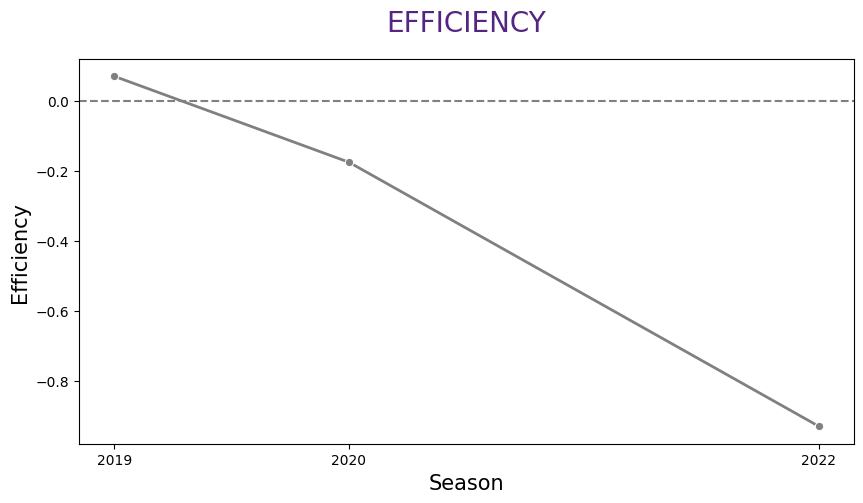

In [493]:
Kendrick19 = Scaleff[(Scaleff['PLAYER_NAME']=='Kendrick Nunn')&(Scaleff['SEASON']==2019)].copy()
bar_Kendrick=pd.concat([Kendrick,Kendrick19]) # 이 부분은 중복 데이터가 생길 수 있으니 주의하세요.

# 보통은 원하는 데이터만 정확히 필터링해서 사용하는 것이 좋습니다.
# 예를 들어, 특정 선수의 모든 시즌 데이터가 필요하면:
# bar_Kendrick = Scaleff[Scaleff['PLAYER_NAME']=='Kendrick Nunn'].sort_values('SEASON').copy()

plt.figure(figsize = (10, 5))

sns.lineplot(data=bar_Kendrick, x='SEASON', y='EFFICIENCY', color='Gray', marker='o', linewidth=2)


plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5)


# --- x축 틱을 정수 단위로 설정하는 부분 추가 ---
# bar_Kendrick에 있는 고유한 시즌 값들을 가져와서 틱으로 설정합니다.
# 만약 틱이 촘촘하지 않게 나오거나, 특정 범위의 틱만 원하면 `range()` 등을 활용할 수 있습니다.
plt.xticks(bar_Kendrick['SEASON'].unique())
# -----------------------------------------------

plt.title('EFFICIENCY',fontsize=20,color='#552583',y=1.05)
plt.xlabel('Season',fontsize=15)
plt.ylabel('Efficiency',fontsize=15)
plt.show()